In [79]:
# Take user input for the url and get the review list url
import re

#Getting user input
url = input("Enter the URL: ")

# Splitting the url and creating the link to the reviews list
url_string = re.split('/dp/', url)
product = url_string[0]
product_id = re.split(r'\?', url_string[1])[0] #Note that we can't do '?' since ? is an expression in re

# Creating the url string for the reviews
review_url = product + '/product-reviews/' + product_id + '/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews'

Enter the URL:  https://www.amazon.com/dp/1616953675/ref=s9_acsd_al_bw_c2_x_6_i?pf_rd_m=ATVPDKIKX0DER&pf_rd_s=merchandised-search-14&pf_rd_r=BN5NXPXRVXMD33K837AH&pf_rd_t=101&pf_rd_p=4174c67c-49fa-4b31-a362-5bd7da5e3c6a&pf_rd_i=283155


In [80]:
# Scraping the reviews from Amazon 

from requests_html import AsyncHTMLSession
from bs4 import BeautifulSoup
import pandas as pd

session = AsyncHTMLSession()
review_data = []

while review_url:
    r = await session.get(review_url)
    await r.html.arender(sleep=5)
    soup = BeautifulSoup(r.html.html, 'lxml')
    reviews = soup.find_all("div", {"data-hook": "review"})
    
    # Getting all the titles and body text from the reviews and adding it to a dictionary
    for x in reviews:
        if x:
            title_element = x.find('a', {'data-hook': 'review-title'})
            body_element = x.find('span', {'data-hook': 'review-body'})

            title = title_element.text.strip() if title_element else ''
            body = body_element.text.strip() if body_element else ''

            review = {
                'title': title,
                'body': body
            }
            review_data.append(review)

    # Finding the link to the next review page 
    next_page_element = soup.find(class_="a-last")
    if next_page_element:
        next_page_link = next_page_element.find('a')
        if next_page_link:
            next_page = 'https://www.amazon.com/' + next_page_link['href']
        else:
            next_page = None
    else:
        next_page = None
    review_url = next_page
print("Done.")

Done.


In [81]:
# Create a dataframe from the text data and clean it 
import pandas as pd

text_data = pd.DataFrame(review_data)
text_data.dropna(inplace=True)
text_data.head()

,title,body
0,A solid follow-up to “Slow Horses”,"If you enjoyed “Slow Horses”, then there will ..."
1,John LeCarré Watch Out!,Second in a delightful spy series in the John ...
2,great thriller,Fun and fast moving the whole way. And funny. ...
3,Pairweevy,"Wonderful characters, ingenious plotting; the ..."
4,First rate spy thriller 4.5 stars,I started reading this series because I really...


In [82]:
# Cleaning the review data

# Getting the body (title is optional, excluded in this case)
#title_list = text_data['title'].to_list()
body_list = text_data['body'].to_list()
# lines = title_list + body_list

# Cleaning the text 
text = " ".join(x.strip() for x in body_list)
text = re.sub('The media could not be loaded', '', text)

# Remove all whitespace using re.sub()
pattern = r'[\t\n]+'  # '\t' matches tabs and '\n' matches newlines, + means more than one
text = re.sub(pattern, '', text)

emoji = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
text = re.sub(emoji, '', text) # removing all emojis

In [83]:
# Pre-processing the data
import string
import contractions
import nltk
import nltk.corpus
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Expanding contractions
text = " ".join(contractions.fix(word) for word in text.split())

# Lowercasing and removing punctuation
text = "".join(i for i in list(text) if i not in string.punctuation).lower()

# Tokenizing the data
text_tokens = word_tokenize(text)

# Removing the stopwords
stopwords = set(stopwords.words('english'))
text_words = [word for word in text_tokens if word not in stopwords]

# Normalize the text
wordnet_lemmatizer = WordNetLemmatizer()
normal_words = []
for w in text_words:
    word1 = wordnet_lemmatizer.lemmatize(w, pos = "n")
    word2 = wordnet_lemmatizer.lemmatize(word1, pos = "v")
    word3 = wordnet_lemmatizer.lemmatize(word2, pos = ("a"))
    normal_words.append(word3)

In [84]:
# Compute the frequency of each word and combine common adjacent phrases
import collections 
import statistics
import numpy as np

# Calculating the frequency of each pair of words
# zip(list, list) combines the two lists into a sequence of tuples, where the first item of each list is paired into a tuple 
adj_words = zip(normal_words, normal_words[1:]) 
adj_words_freq = collections.Counter(adj_words)

# Getting the max frequency of the pairs 
max_freq = np.percentile(list(set(adj_words_freq.values())), 75)


# Craeting a dictionary of those most frequent pairs 
pairs = {adj: count for adj, count in adj_words_freq.items() if count > max_freq}
pairs_joined = {}
for key, value in pairs.items():
    pairs_joined["_".join(key)] = value

# Getting the most popular solor words based on the median of the freqs
s_words = dict(collections.Counter(normal_words))
cut_off = statistics.median(set(s_words.values())) - 2
solo_words = {word: freq for word, freq in s_words.items() if freq >= cut_off}


# Combining both together
cloud_list = {}
cloud_list.update(solo_words)
cloud_list.update(pairs_joined)
print(cloud_list)

{'enjoy': 73, 'slow': 176, 'horse': 167, 'first': 117, 'book': 356, 'bite': 52, 'find': 83, 'second': 83, 'series': 229, 'read': 222, 'love': 55, 'good': 154, 'much': 53, 'author': 63, 'new': 44, 'dead': 74, 'lion': 59, 'story': 135, 'character': 238, 'herron': 137, 'slough': 152, 'house': 147, 'well': 100, 'get': 111, '’': 70, 'end': 74, 'make': 78, 'think': 60, 'come': 47, 'back': 57, 'another': 44, 'one': 126, 'could': 44, 'great': 85, 'spy': 137, 'way': 55, 'british': 42, 'would': 71, 'work': 46, 'plot': 164, 'look': 54, 'start': 57, 'really': 54, 'like': 99, 'agent': 47, 'reader': 58, 'jackson': 98, 'lamb': 151, 'know': 56, 'mi5': 65, 'time': 59, 'mick': 85, 'still': 44, 'novel': 81, 'write': 99, 'go': 61, 'old': 42, 'thriller': 51, 'le': 42, 'keep': 46, 'slow_horse': 155, 'first_book': 42, 'book_series': 37, 'dead_lion': 55, 'slough_house': 141, 'jackson_lamb': 94, 'mick_herron': 66}


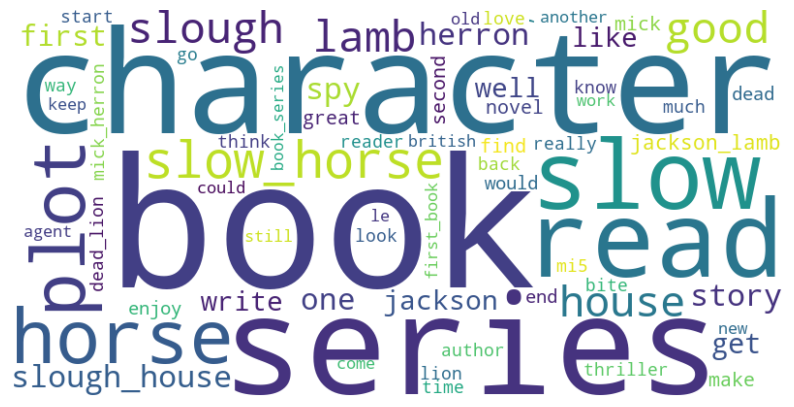

In [87]:
# Creating the word cloud
# !pip install wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white")
wordcloud.generate_from_frequencies(cloud_list)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()